# Milestone 2

In [62]:
from cProfile import label

from altair import XOffset
from matplotlib.pyplot import ylabel, title
from networkx.algorithms.bipartite.basic import color
from scipy.stats import binned_statistic
from streamlit import columns
from src.models import model_start
import config
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
# all imports
from src import *
import pandas as pd
import os.path

## Data acquisition

In [64]:
filename = './data/dataframe_2016_to_2019.csv'
start_year = 2016
end_year = 2019

if not os.path.isfile(filename):
    # Get the data from the NHL API (2016 - 2019)
    nhl_data_provider = get_data_from(start_year, end_year)

    # Clean the data
    clean_regular_season, clean_playoff = clean_data(nhl_data_provider)

    # Transform data into dataframe
    df_2016_to_2019 = convert_dictionaries_to_dataframes(clean_regular_season,
                                                         clean_playoff,
                                                         np.arange(start_year, end_year + 1).tolist())
    df_2016_to_2019.to_csv(filename, index=False)

In [65]:
train_data = pd.read_csv(filename)

# Ingénierie des caractéristiques

## Question 1

In [66]:
train_data['isGoal'] = train_data['typeDescKey'].apply(lambda x: 1 if x == 'goal' else 0)
train_data['emptyGoalNet'] = train_data['emptyGoalNet'].astype(int)

In [67]:
count_table = pd.crosstab(train_data['isGoal'], train_data['typeDescKey'])
# count_table2 = pd.crosstab(train_data['emptyGoalNet_0_1'],train_data['emptyGoalNet'])

count_table
# count_table2

typeDescKey,goal,shot-on-goal
isGoal,,
0,0,296406
1,30936,0


#### Histogramme du nombre de tirs (buts et non-buts séparés), regroupés par distance

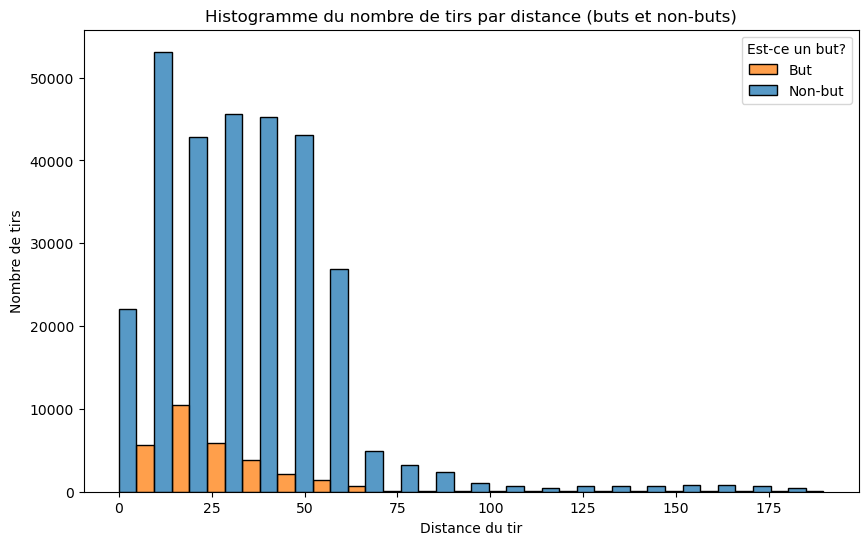

In [68]:
## Add in advancedVisualisation (by Youry)
def histogram_2_variables(df, x, hue, bins, xlabel, ylabel, title, legendTitle, legendLabels):
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=x, hue=hue, bins=bins, multiple='dodge')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(title=legendTitle, labels=legendLabels)
    plt.show()


histogram_2_variables(df=train_data, x='shotDistance', hue='isGoal', bins=20, xlabel='Distance du tir',
                      ylabel='Nombre de tirs', title='Histogramme du nombre de tirs par distance (buts et non-buts)',
                      legendTitle='Est-ce un but?', legendLabels=['But', 'Non-but'])

#### Histogramme du nombre de tirs (buts et non-buts séparés), regroupés par angle

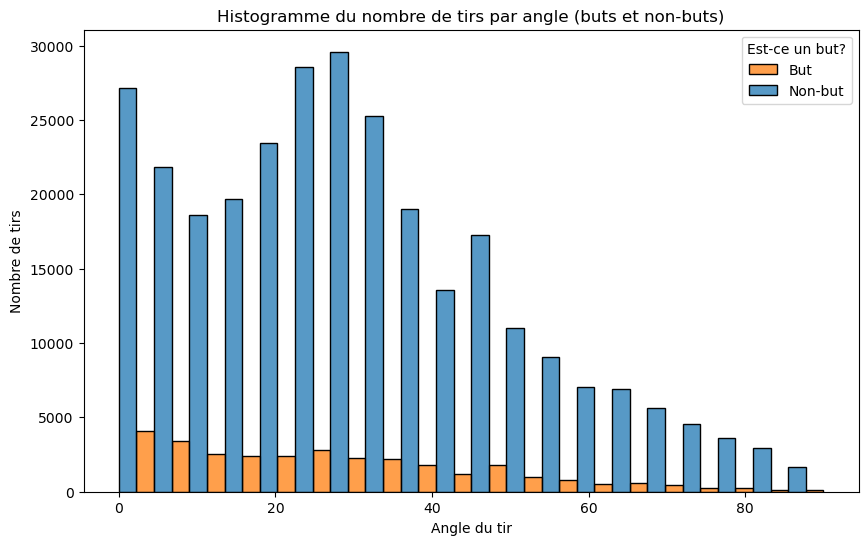

In [69]:
histogram_2_variables(train_data, x='shotAngle', hue='isGoal', bins=20, xlabel='Angle du tir', ylabel='Nombre de tirs',
                      title='Histogramme du nombre de tirs par angle (buts et non-buts)', legendTitle='Est-ce un but?',
                      legendLabels=['But', 'Non-but'])

#### Histogramme 2D où un axe est la distance et l'autre est l'angle (sans distinction entre buts et non-buts)

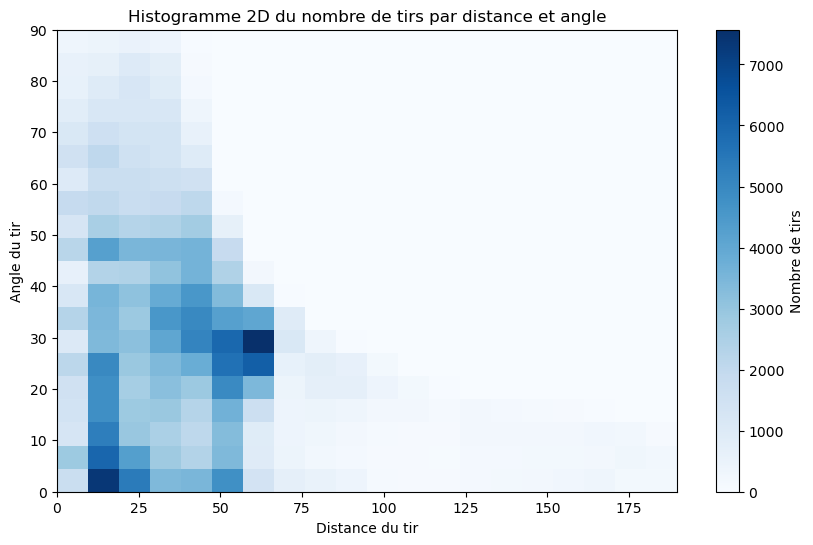

In [70]:
def histogram2D_2_variables(df, x, y, bins, label, xlabel, ylabel, title):
    # Remove rows with NaN values
    df = df.dropna(subset=[x, y])
    # Plot the histogram with hue for 'is_goal'
    plt.figure(figsize=(10, 6))
    plt.hist2d(df[x], df[y], bins=bins, cmap='Blues')
    # Customize legend labels for hue values
    plt.colorbar(label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()


histogram2D_2_variables(train_data, x='shotDistance', y='shotAngle', bins=20, label='Nombre de tirs',
                        xlabel='Distance du tir', ylabel='Angle du tir',
                        title='Histogramme 2D du nombre de tirs par distance et angle')

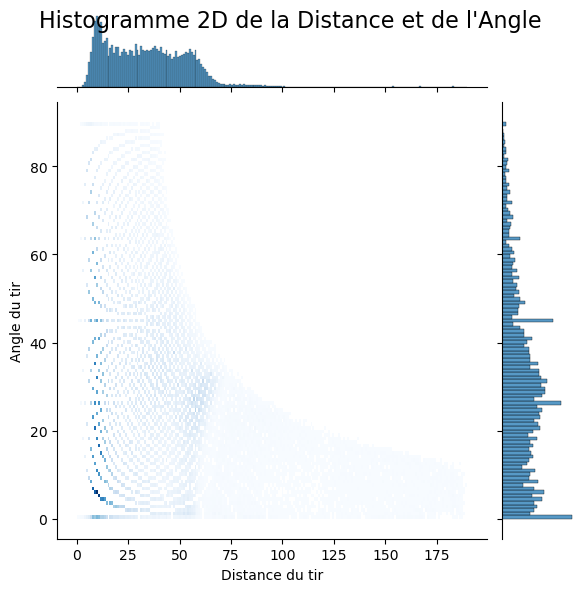

In [71]:
def histogram2D_2_variables_seaborn(df, x, y, kind, title, xlabel, ylabel):
    # Remove rows with NaN values
    df = df.dropna(subset=[x, y])
    # Jointplot to visualize the 2D histogram
    sns.jointplot(data=df, x=x, y=y, kind=kind, cmap='Blues')
    # Add title and labels
    plt.suptitle(title, fontsize=16)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # Show the plot
    plt.show()


histogram2D_2_variables_seaborn(train_data, x='shotDistance', y='shotAngle', kind='hist',
                                title="Histogramme 2D de la Distance et de l'Angle", xlabel='Distance du tir',
                                ylabel='Angle du tir')

## Question 2

#### Le taux de but (buts / (buts + non-buts)) par distance

In [72]:
df_distance_goal_rate = train_data.groupby('shotDistance')['isGoal'].mean().reset_index()
df_distance_goal_rate.columns = ['shotDistance', 'goalRate']

df_distance_goal_rate


,shotDistance,goalRate
0,0.0,1.000000
1,1.0,1.000000
2,1.4,0.777778
3,2.0,0.500000
4,2.2,0.550000
...,...,...
1769,188.0,0.500000
1770,188.1,0.000000
1771,188.2,0.000000
1772,188.4,0.000000


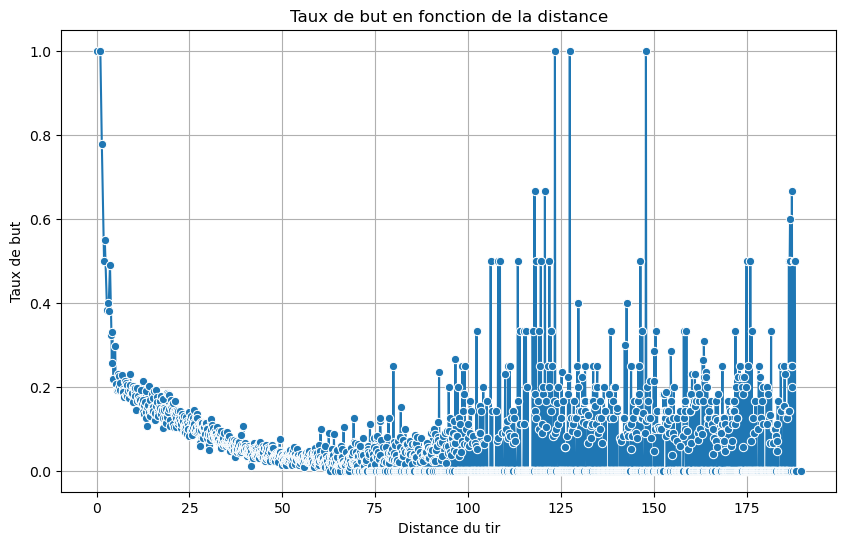

In [73]:
def lineplot_2_variables(df, x, y, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x=x, y=y, marker='o')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.show()


lineplot_2_variables(df=df_distance_goal_rate, x='shotDistance', y='goalRate',
                     title='Taux de but en fonction de la distance', xlabel='Distance du tir', ylabel='Taux de but')

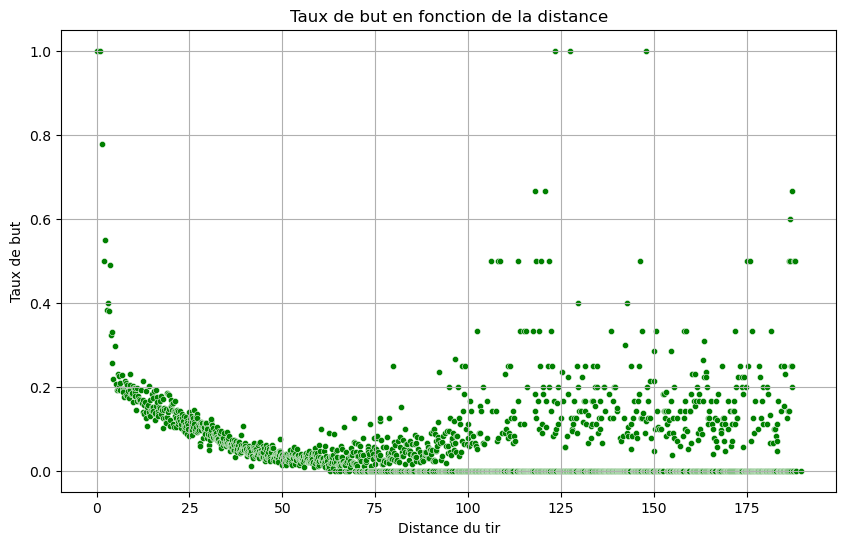

In [74]:
def scatterplot_2_variables(df, x, y, color, s, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x=x, y=y, color=color, s=s, marker='o')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.show()


scatterplot_2_variables(df=df_distance_goal_rate, x='shotDistance', y='goalRate', color='green', s=20,
                        title='Taux de but en fonction de la distance', xlabel='Distance du tir', ylabel='Taux de but')

#### Le taux de but (buts / (buts + non-buts)) par angle

In [75]:
df_angle_goal_rate = train_data.groupby('shotAngle')['isGoal'].mean().reset_index()
df_angle_goal_rate.columns = ['shotAngle', 'goalRate']

df_angle_goal_rate

,shotAngle,goalRate
0,0.000000,0.182048
1,0.306392,0.000000
2,0.309704,0.000000
3,0.329282,0.000000
4,0.331186,0.000000
...,...,...
4499,88.451842,0.000000
4500,88.492564,0.000000
4501,88.531199,0.000000
4502,88.567904,0.250000


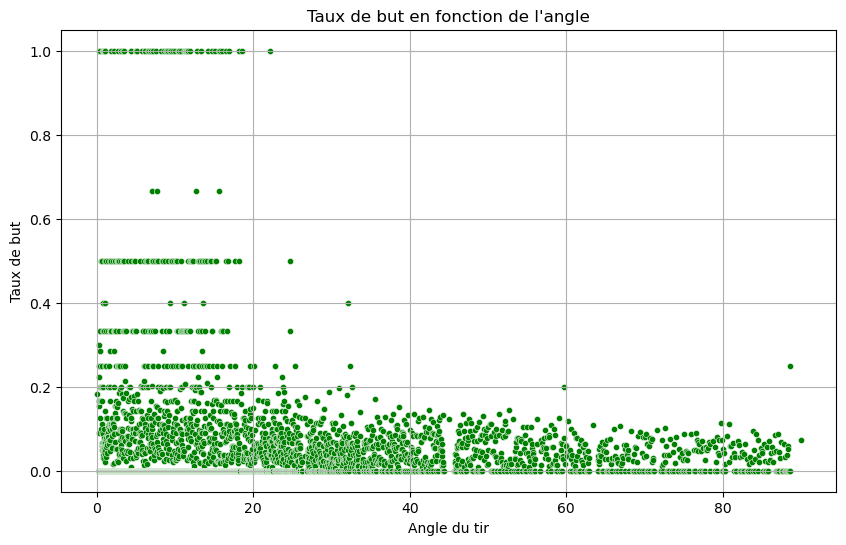

In [76]:
scatterplot_2_variables(df=df_angle_goal_rate, x='shotAngle', y='goalRate', color='green', s=20,
                        title='Taux de but en fonction de l\'angle', xlabel='Angle du tir', ylabel='Taux de but')

## Question 3

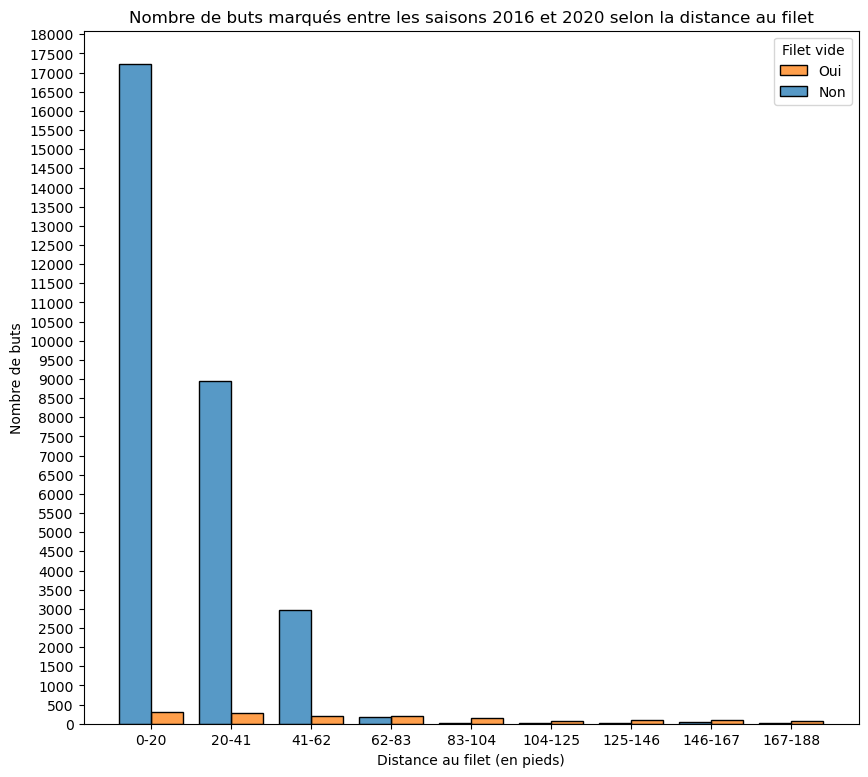

In [77]:
plot_goals_by_distance(train_data)

### Nombre de buts net non vides marqués depuis l'intérieur de la zone défensive

In [78]:
filtered_data = train_data[(train_data['shotDistance'] > 90) & (train_data['typeDescKey'] == 'goal') & (train_data['emptyGoalNet'] == 0)]
len(filtered_data)

118

In [79]:
filtered_data.loc[54362,:]

Year                                  2016
idGame                          2016020894
gameType                    regular-season
periodType                              SO
numberPeriod                             5
typeDescKey                           goal
eventOwnerTeam                     Rangers
Game Seconds                          4800
previousEventType             shot-on-goal
timeSinceLastEvent                     0.0
previousXCoord                        74.0
previousYCoord                        -3.0
xCoord                               -71.0
yCoord                                 5.0
zoneShoot                                O
shootingPlayer             Mats Zuccarello
goaliePlayer             Frederik Andersen
shotType                          backhand
teamSide                              away
emptyGoalNet                             0
isGoalAdvantage                  Advantage
shotDistance                         160.1
distanceFromLastEvent                145.2
rebound    

In [80]:
# l'venement 54362 (filtered_data.loc[54362,:]) du match 2016020894 n'a pas les bonnes coordonées. 
# voir la vidéo: https://www.youtube.com/watch?v=lM6JXVW0-YY du match. le but de Mats Zuccarello en période de shoot-out
# est fait du coté droit, non du coté gauche

# l'evenemnt 80622 du match 2017020004 n'a pas les bonnes coordonées.
# voir la vidéo: https://www.youtube.com/watch?v=WpIGr7srlLY. le but de Kevin Labanc est du mauvais coté

# l'evenemnet 1806 n'a pas le bon zoneShoot/zoneCode. il a comme zoneShoot D (defensive) alors que quand on regarde le but de
# John Tavares, il le marque bien dans la zone offensive https://www.youtube.com/watch?v=MO7vAygX2_c

### Nombre de buts marqués depuis l'intérieur de la zone défensive

In [81]:
filtered_data = train_data[(train_data['shotDistance'] > 90) & (train_data['typeDescKey'] == 'goal')]

grouped_df = filtered_data.groupby(['shotType']).count()

print(grouped_df['idGame'])

shotType
backhand        36
deflected        2
slap            34
snap            41
tip-in          18
wrap-around      1
wrist          437
Name: idGame, dtype: int64


In [82]:
filtered_data[filtered_data['shotType'] == 'wrap-around']

,Year,idGame,gameType,periodType,numberPeriod,typeDescKey,eventOwnerTeam,Game Seconds,previousEventType,timeSinceLastEvent,...,emptyGoalNet,isGoalAdvantage,shotDistance,distanceFromLastEvent,rebound,speedFromLastEvent,shotAngle,reboundAngleShot,offensivePressureTime,isGoal
47255,2016,2016020779,regular-season,REG,3,goal,Penguins,3582,takeaway,2.0,...,1,Disadvantage,92.0,22.1,False,11.05,0.622756,0.0,101.0,1


In [83]:
# pour l'evenement 47255 du match 2016020779, le type de tir n'est pas correct car un wrap-around ne peut pas se faire aussi loin
# voir: https://www.nhl.com/gamecenter/pit-vs-stl/2017/02/04/2016020779/playbyplay
# video: https://www.youtube.com/watch?v=CHcbWHyRDbE. Sidney Crosby a bien tiré depuis la position (3,1). donc les coordonées et la distance sont 
# bonnes. Le type de tir n'est pas le bon. 

# video wrap-around: https://www.youtube.com/watch?v=tmRibUXW8RE

# Modèles de base

In [84]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

#### Préparation de la caractéristique et de la cible

In [85]:
# Préparation de la caractéristique et de la cible
X = train_data[['shotDistance']].dropna()
y = train_data['isGoal'][X.index]

In [86]:
# Division des données en ensembles d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X, y)

In [87]:
# # Vérification des types et absence de NaN
# print("Type de X_train:", type(X_train))
# print("Type de y_train:", type(y_train))
# print("Valeurs manquantes dans X_train:", X_train.isnull().sum().sum())
# print("Valeurs manquantes dans y_train:", y_train.isnull().sum())

#### Entraîner le modèle

In [88]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

#### Prédiction et évaluation

In [89]:
# Prédiction et évaluation
y_pred = clf.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
f1_score = f1_score(y_val, y_pred, average="macro")
print(f"Précision du modèle sur l'ensemble de validation: {accuracy:.2f}")
print(f"F1-score du modèle sur l'ensemble de validation: {f1_score:.2f}") 

Précision du modèle sur l'ensemble de validation: 0.91
F1-score du modèle sur l'ensemble de validation: 0.48


## Question 5

### Ajout de l'artefact sur Wandb

In [90]:
import wandb

# Connect to the Wandb API
api = wandb.Api()

# Spécifiez votre projet
project_name = "IFT6758.2024-A11" 
entity = "youry-macius-universite-de-montreal"  

try:
    artifact = api.artifact(f'{entity}/{project_name}/wpg_v_wsh_2017021065:latest')
    print("L'artefact existe déjà.")
except wandb.errors.CommError as e:
    run = wandb.init(project="IFT6758.2024-A11")
    
    # Create artefact
    artifact = wandb.Artifact(
        "wpg_v_wsh_2017021065",
        type="dataset"
    )
    
    # add data
    my_table = wandb.Table(dataframe=train_data[train_data['idGame'] == 2017021065])
    artifact.add(my_table, "wpg_v_wsh_2017021065")
    run.log_artifact(artifact)


L'artefact existe déjà.


In [91]:
config.INPUTS_DOCUMENTS = X.to_numpy()
config.LABELS_DOCUMENTS = y.to_numpy()
model_start.optimize("MLP_H1")
model_start.predict_data("MLP_H1")

device: cpu


DuplicatedStudyError: Another study with name 'Perceptron Optimizer - 11/17-13:50:58' already exists. Please specify a different name, or reuse the existing one by setting `load_if_exists` (for Python API) or `--skip-if-exists` flag (for CLI).